In [1]:
import pandas as pd
from datetime import datetime

In [2]:
df = pd.read_csv("data/df_hack_final.csv")

#### Формат имен признаков:
- Ni_rec – извлечение никеля в готовый никелевый продукт, концентрат (значение может отсутствовать, валидны только меньше 1 и больше 0),
- Ore, oreth – имена, которые означают признаки рудного сгустителя (Ore thickener) и на входе первой ФМ (напомним, ФМ – флотомашина),
- resth – имена, которые означают признаки сгустителя с готовым никелевым продуктом (Final Ni thickener).
- Физические характеристики: Mass (масса), Dens (плотность), Vol (объём), Ni (никель), Cu (медь), AU (флаг автоуправления, если оптимизатор управления ФМ включен, то равен 1 – фактические диапазоны на этой ФМ актуальны, в противном случае диапазонам не следует доверять, так как не обновлялись после выключения оптимизатора)
- Суффиксы имён ФМ (положения в цепи агрегатов): 1.1, 1.2, …, 6.2 (см Схему флотации).
- Суффиксы продуктов: F – питание ФМ, C – концентрат ФМ, T – хвосты ФМ.
- Суффиксы границ фактических диапазонов, которые были выставлены технологом для оптимизатора ФМ: min, max.


In [3]:
df = df.astype({'MEAS_DT': 'datetime64[ns]'})

In [4]:
df.describe()

,MEAS_DT,Cu_oreth,Ni_oreth,Ore_mass,Mass_1,Mass_2,Dens_4,Mass_4,Vol_4,Cu_4F,...,Cu_3.1T_max,Cu_3.1T_min,FM_3.2_A,Cu_3.2C_max,Cu_3.2C_min,Ni_3.2C_max,Ni_3.2C_min,Cu_3.2T_max,Cu_3.2T_min,Ni_rec
count,30336,26213.000000,26213.000000,30336.000000,30336.000000,30336.000000,30336.000000,30336.000000,30336.000000,26083.000000,...,30335.000000,30335.000000,30335.000000,30335.000000,30335.000000,3.033500e+04,30335.0,30335.000000,30335.000000,27759.000000
mean,2024-06-06 23:52:29.999999744,2.712405,1.685584,1213.996028,1346.755948,789.375929,1.386676,811.542840,1520.387530,0.477034,...,1.627824,0.818042,0.331235,15.653601,13.036163,3.700000e+00,3.5,1.576072,0.863170,0.947898
min,2024-01-01 00:00:00,1.654600,1.141700,0.000000,-0.258293,-0.167950,0.000000,-0.083749,0.000000,0.100100,...,1.000000,0.600000,0.000000,14.000000,12.000000,3.700000e+00,3.5,1.000000,0.600000,0.594336
25%,2024-03-19 23:56:15,2.523700,1.574000,1133.500000,1310.454010,762.188248,1.378594,791.388550,1523.531250,0.396900,...,1.400000,0.600000,0.000000,15.000000,13.000000,3.700000e+00,3.5,1.400000,0.700000,0.933853
50%,2024-06-06 23:52:30,2.694400,1.685100,1274.500000,1400.961060,817.151642,1.398115,836.229218,1562.812500,0.468100,...,1.800000,0.800000,0.000000,15.500000,13.000000,3.700000e+00,3.5,1.600000,0.900000,0.943993
75%,2024-08-24 23:48:45,2.894800,1.792700,1395.500000,1475.273743,864.989029,1.415396,875.025543,1595.750000,0.541200,...,1.800000,0.900000,1.000000,16.500000,13.000000,3.700000e+00,3.5,1.800000,1.000000,0.966216
max,2024-11-11 23:45:00,4.048000,2.617300,2000.000000,2089.517578,1221.758057,1.651951,1303.474609,2028.375000,5.205700,...,2.000000,1.200000,1.000000,17.000000,15.000000,3.700000e+00,3.5,1.800000,1.300000,1.000000
std,NaN,0.284495,0.163395,304.202121,272.748762,153.755873,0.072671,147.976016,254.858332,0.176787,...,0.328567,0.170884,0.470665,0.901482,0.573167,8.881931e-16,0.0,0.236993,0.166731,0.020704


#### Отбор данных под каждую флотомашину

In [5]:
import re

In [6]:
def get_dataframe_per_fm(df, i, j):
    non_digit_features = [col for col in df.columns.tolist() if not re.findall(r'\d+', col)]
    filtered_columns_1 = [col for col in df.columns.tolist() if re.findall(f'{i}\\.{j}', col)]
    filtered_columns_2 = [col for col in df.columns.tolist() if re.findall(f'_{i}$', col)]
    return df[non_digit_features+filtered_columns_1+filtered_columns_2]

dfd = {f"fm{i}.{j}" : get_dataframe_per_fm(df, i, j) for j in range(1,3) for i in range(1,7)}

##### Чтение тестовых данных + дока

Требуется заполнить файл test.csv, указав границы диапазонов признаков (20 признаков => 40 значений границ) для выбранных моментов времени. Эти таймстемпы – 20 непрерывных временных отрезков с 15-минутной дискретностью. Каждый отрезок–тест-кейс, который будет оцениваться отдельно.

In [7]:
test_dataframe = pd.read_csv("data/test.csv")

Важно! Границы фактического диапазона в файле исходных данных – значения, которые выставляли технологи производства для сервиса оптимизации флотации (по одному на каждую линию флотомашины, например, оптимизатор для ФМ1.1.), чтобы этот оптимизатор генерировал воздействия на рычаги управления флотацией на ФМ, которые обеспечат сходимость к середине этого диапазона. Обратите внимание, что сами границы, как и ширина диапазона – плод интеллектуального труда и фантазии технологов, которые работают посменно. Технолог ведёт процесс, наблюдает за большим кол-вом параметров и не всегда уделяет достаточное внимание оптимизатору и этим диапазонам – учитывайте человеческий фактор! Наиболее релевантные значения – при включении оптимизатора (см смену значения признака с суффиксом AU с 0 на 1).
В данной задаче все границы фактических диапазонов (40 параметров типа min, max) для каждой 15-минутки ставим под сомнение и предлагаем вам сгенерировать свои варианты с учётом ограничений:
1. Каждый диапазон (признаки min, max) можно изменить не чаще 1 раза в 2 часа (не менее 8 15-минуток подряд с одной и той же парой значений границ).
2. Наименьшие допустимые приращения признаков min, max зависят от продукта, металла и ФМ (и одинаковы для двух линий одной ФМ). В качестве приращений используйте только кратные им значения (например, если наименьшее допустимое – 0.1, используйте 0.1, 0.2, 0.3, …):
    - Ni_1.*C – 0.1,
    - Cu_1.*C – 0.1,
    - Cu_2.*T – 0.01,
    - Cu_3.*T – 0.05,
    - Ni_4.*T – 0.01,
    - Ni_4.*C – 0.05,
    - Ni_5.*T – 0.01,
    - Ni_5.*C – 0.05,
    - Ni_6.*T – 0.01,
    - Ni_6.*C – 0.05.

## prophet

In [8]:
import pandas as pd
from prophet import Prophet

In [9]:
dfp = dfd["fm1.1"]
dfp = dfp[['MEAS_DT', 'Cu_1.1C']]
dfp.columns = ['ds', 'y']

In [11]:
m.make_future_dataframe?

Signature: m.make_future_dataframe(periods, freq='D', include_history=True)
Docstring:
Simulate the trend using the extrapolated generative model.

Parameters
----------
periods: Int number of periods to forecast forward.
freq: Any valid frequency for pd.date_range, such as 'D' or 'M'.
include_history: Boolean to include the historical dates in the data
    frame for predictions.

Returns
-------
pd.Dataframe that extends forward from the end of self.history for the
requested number of periods.
File:      ~/Documents/NORNICKEL_HACK/venv/lib/python3.12/site-packages/prophet/forecaster.py
Type:      method

In [13]:
m = Prophet(changepoint_prior_scale=0.01).fit(dfp)

07:11:44 - cmdstanpy - INFO - Chain [1] start processing
07:11:48 - cmdstanpy - INFO - Chain [1] done processing


/Users/fedorkurusin/Documents/NORNICKEL_HACK/venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


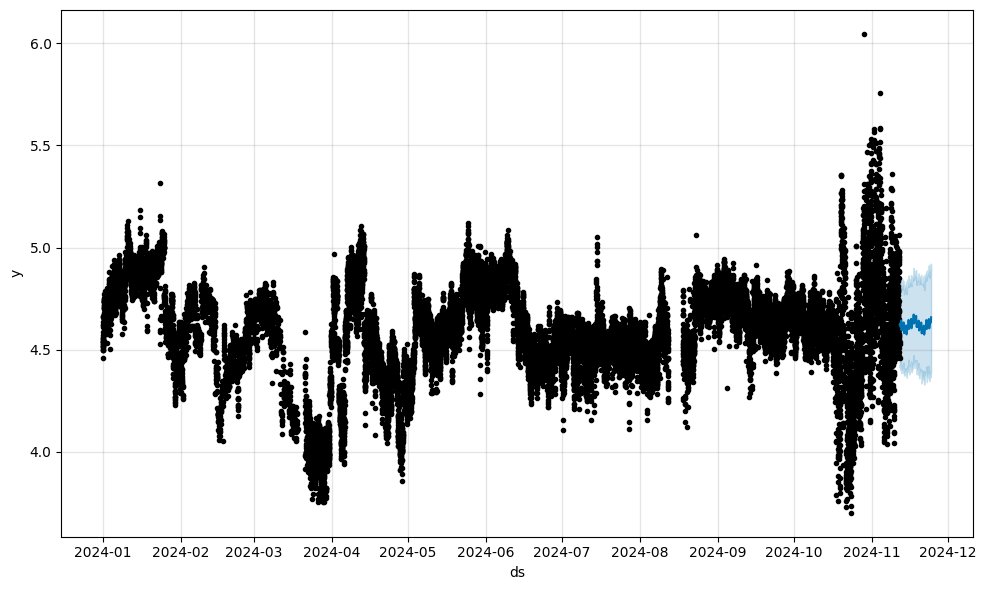

In [19]:
future = m.make_future_dataframe(periods=300, freq='H', include_history=False)
fcst = m.predict(future)
fig = m.plot(fcst)

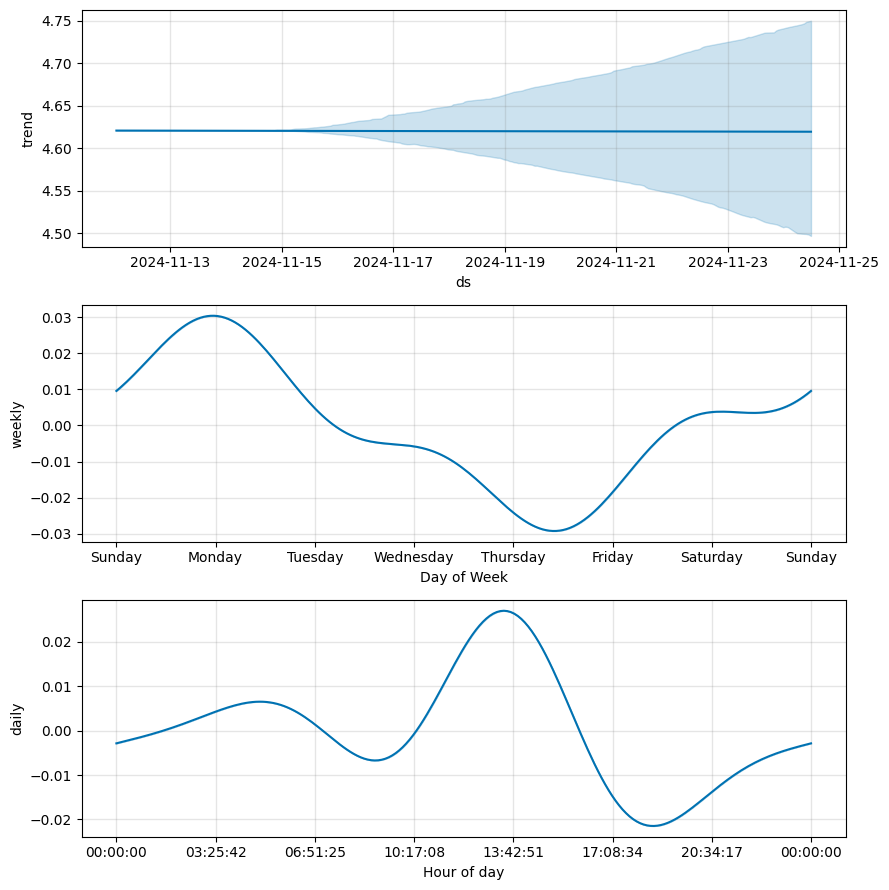

In [20]:
fig = m.plot_components(fcst)

In [75]:
dfp['cap'] = dfp.y.max()
dfp['floor'] = dfp.y.min()

/var/folders/26/lwt6j_fx7_n00nrjqff36kfm0000gn/T/ipykernel_95611/900617540.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp['cap'] = dfp.y.max()
/var/folders/26/lwt6j_fx7_n00nrjqff36kfm0000gn/T/ipykernel_95611/900617540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp['floor'] = dfp.y.min()


In [ ]:
dfp_train = dfp.loc[:30_200]
dfp_test = dfp.loc[30_200:]

# Python
m = Prophet(growth='logistic')
m.fit(dfp_train)

future = dfp_test[['ds', 'cap', 'floor']]


forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

23:12:09 - cmdstanpy - INFO - Chain [1] start processing
23:12:17 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
131,2024-11-11 22:45:00,4.594666,4.382272,4.831350
132,2024-11-11 23:00:00,4.594935,4.379825,4.835308
133,2024-11-11 23:15:00,4.595157,4.373772,4.835706
134,2024-11-11 23:30:00,4.595345,4.373654,4.813868
135,2024-11-11 23:45:00,4.595508,4.364712,4.810687


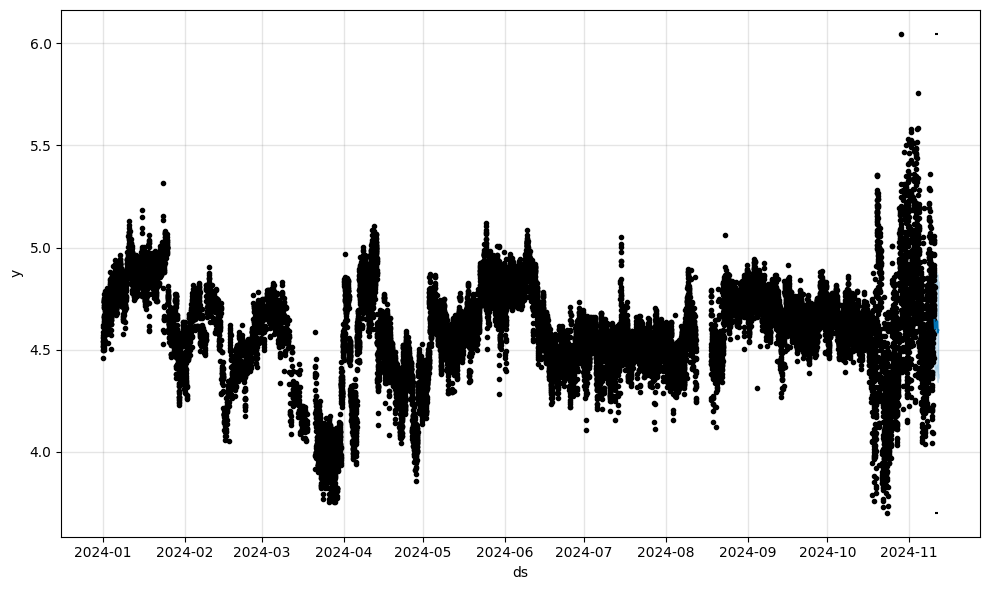

In [79]:
# Python
fig1 = m.plot(forecast)

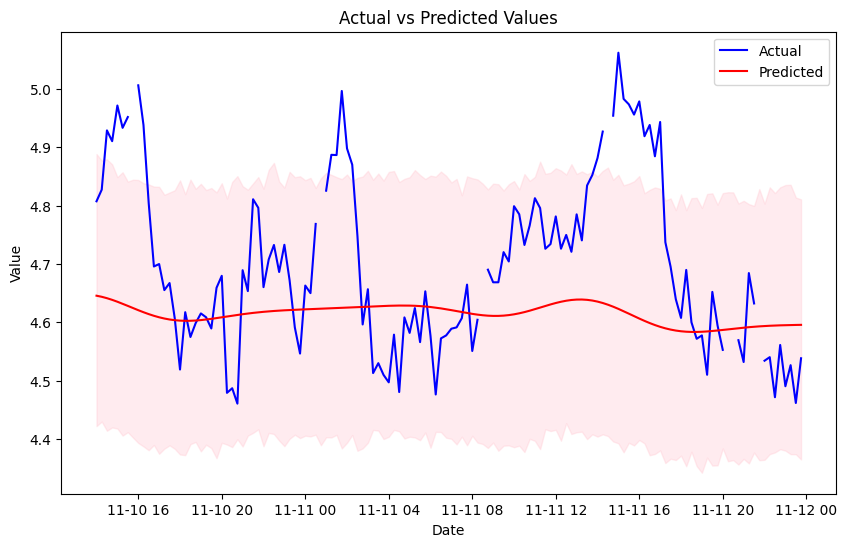

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(dfp_test['ds'], dfp_test['y'], label='Actual', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [80]:
# Python
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
30226,2024-12-06 14:00:00
30227,2024-12-07 14:00:00
30228,2024-12-08 14:00:00
30229,2024-12-09 14:00:00
30230,2024-12-10 14:00:00


In [82]:
future['cap'] = dfp.y.max()
future['floor'] = dfp.y.min()

In [83]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
30226,2024-12-06 14:00:00,4.589843,4.292832,4.906177
30227,2024-12-07 14:00:00,4.594334,4.291733,4.912244
30228,2024-12-08 14:00:00,4.613263,4.288916,4.934777
30229,2024-12-09 14:00:00,4.603183,4.257508,4.929559
30230,2024-12-10 14:00:00,4.582097,4.240554,4.951979


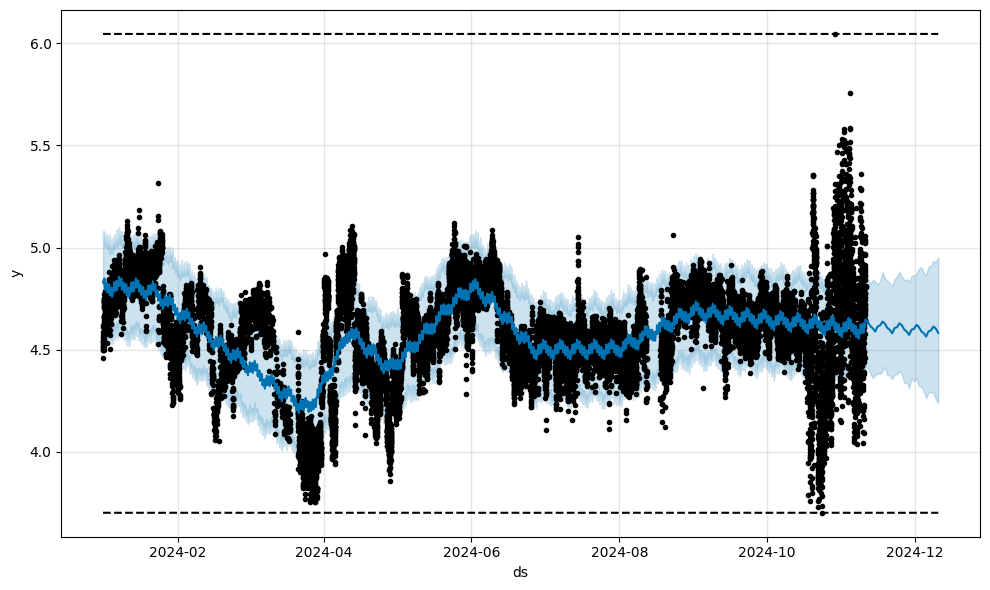

In [84]:
fig1 = m.plot(forecast)

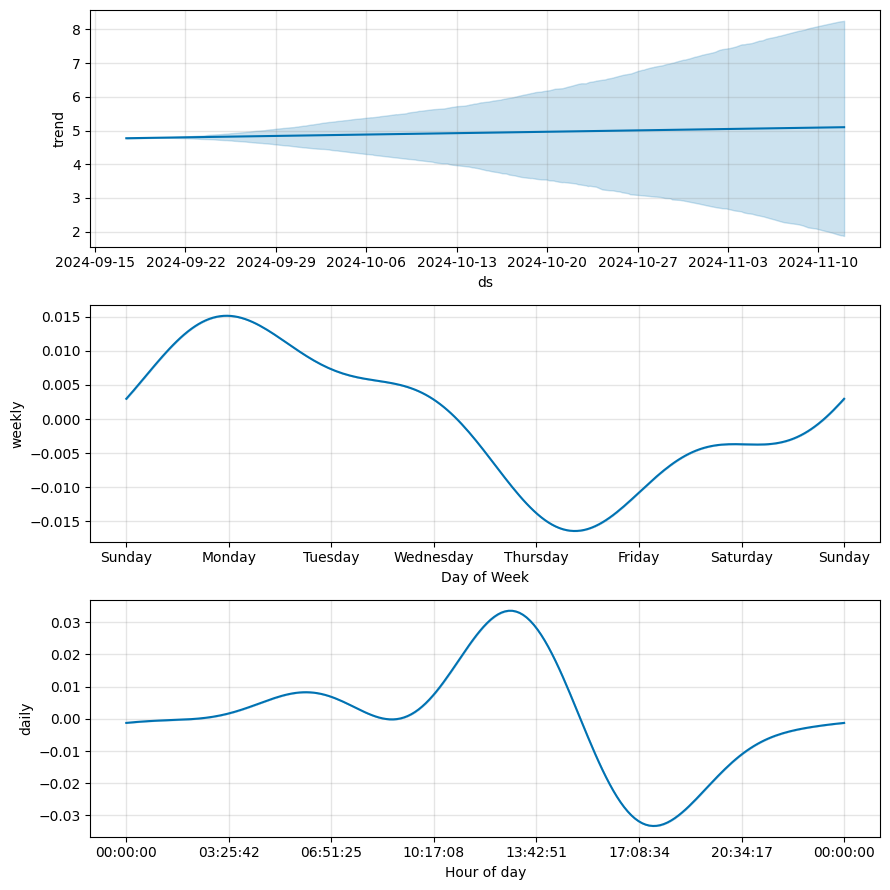

In [44]:
# Python
fig2 = m.plot_components(forecast)

In [ ]:
# Python
# future = m.make_future_dataframe(periods=365)
# future.tail()

In [9]:
# test_dataframe.isna().sum()

In [10]:
test_dataframe = test_dataframe.astype({'MEAS_DT': 'datetime64[ns]'})

In [11]:
dfd_test = {f"fm{i}.{j}" : get_dataframe_per_fm(test_dataframe, i, j) for j in range(1, 3) for i in range(1, 7)}

In [12]:
def train_test_split(train_, test_):
    train = pd.concat([train_, test_]).drop_duplicates(subset='MEAS_DT', keep=False)
    test = pd.merge(test_, train_, how='inner', on='MEAS_DT', suffixes=('_y', '_X'))
    return {
        "train" : train, 
        "test" : test
        }

In [13]:
dfd_tt = {k : train_test_split(df_train_fm, dfd_test[k]) for k, df_train_fm in dfd.items()}

In [45]:
# dfd_tt['fm1.1']['test']

feadture processing
- MEAS_DT dropping
- nan processing (catboost do it by itself) **[metric/loss-function RMSE do not allows nan value on target]**
- we have also 4 features to predict so, we number of models should have been around 6 * 2 * 4 = 48

In [37]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error
import numpy as np

In [53]:
models = {}
mae_values = {}
mape_values = {}

In [54]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
for floatmachine_name in dfd_tt.keys():

    train = dfd_tt[floatmachine_name]['train']
    test = dfd_tt[floatmachine_name]['test']

    output_features = [f.replace("_y", "") for f in test.columns.tolist() if "_y" in f]
    train = train.dropna(subset=output_features)

    for output_feature in output_features:
        print(f"training {floatmachine_name} : {output_feature}...")

        features_to_train_on = train.columns.tolist()
        features_to_train_on.remove('MEAS_DT')
        features_to_train_on = [f for f in features_to_train_on if not "min" in f and "max" not in f]

        train_pool = Pool(train[features_to_train_on], label=train[output_feature])
        test_pool = Pool(test[features_to_train_on], label=test[output_feature + "_X"])

        model = CatBoostRegressor()

        model.fit(train_pool, eval_set=test_pool, use_best_model=True, plot=False, silent=True)

        train_predictions = model.predict(train_pool)
        test_predictions = model.predict(test_pool)

        train_mae = mean_absolute_error(train[output_feature], train_predictions)
        test_mae = mean_absolute_error(test[output_feature + "_X"], test_predictions)

        train_mape = mean_absolute_percentage_error(train[output_feature], train_predictions)
        test_mape = mean_absolute_percentage_error(test[output_feature + "_X"], test_predictions)
 
        if output_feature not in mae_values:
            mae_values[output_feature] = []
            mape_values[output_feature] = []

        mae_values[output_feature].append(test_mae)
        mape_values[output_feature].append(test_mape)

        print(f"Metrics for {floatmachine_name} : {output_feature}")
        print(f"Train MAE: {round(train_mae, 4)}, Train MAPE: {round(train_mape, 4)}%")
        print(f"Test MAE: {round(test_mae, 4)}, Test MAPE: {round(test_mape, 4)}%")
        print("----------------------------------//----------------------------------")

        models[f"{floatmachine_name}:{output_feature}"] = model

training fm1.1 : Ni_1.1C_min...
Metrics for fm1.1 : Ni_1.1C_min
Train MAE: 0.0468, Train MAPE: 1.7921%
Test MAE: 0.0435, Test MAPE: 1.6678%
----------------------------------//----------------------------------
training fm1.1 : Ni_1.1C_max...
Metrics for fm1.1 : Ni_1.1C_max
Train MAE: 0.0626, Train MAPE: 1.9974%
Test MAE: 0.0943, Test MAPE: 3.0664%
----------------------------------//----------------------------------
training fm1.1 : Cu_1.1C_min...
Metrics for fm1.1 : Cu_1.1C_min
Train MAE: 0.0815, Train MAPE: 1.8806%
Test MAE: 0.1097, Test MAPE: 2.5794%
----------------------------------//----------------------------------
training fm1.1 : Cu_1.1C_max...
Metrics for fm1.1 : Cu_1.1C_max
Train MAE: 0.0441, Train MAPE: 0.908%
Test MAE: 0.042, Test MAPE: 0.8639%
----------------------------------//----------------------------------
training fm2.1 : Cu_2.1T_min...
Metrics for fm2.1 : Cu_2.1T_min
Train MAE: 0.007, Train MAPE: 2.4123%
Test MAE: 0.0192, Test MAPE: 6.6704%
-------------------

In [41]:
for output_feature in mae_values.keys():
    mean_mae = sum(mae_values[output_feature]) / len(mae_values[output_feature])
    mean_mape = sum(mape_values[output_feature]) / len(mape_values[output_feature])
    print(f"Mean MAE for {output_feature}: {round(mean_mae, 4)}")
    print(f"Mean MAPE for {output_feature}: {round(mean_mape, 4)}%")

Mean MAE for Ni_1.1C_min: 0.0435
Mean MAPE for Ni_1.1C_min: 1.6678%
Mean MAE for Ni_1.1C_max: 0.0943
Mean MAPE for Ni_1.1C_max: 3.0664%
Mean MAE for Cu_1.1C_min: 0.1097
Mean MAPE for Cu_1.1C_min: 2.5794%
Mean MAE for Cu_1.1C_max: 0.042
Mean MAPE for Cu_1.1C_max: 0.8639%
Mean MAE for Cu_2.1T_min: 0.0192
Mean MAPE for Cu_2.1T_min: 6.6704%
Mean MAE for Cu_2.1T_max: 0.0133
Mean MAPE for Cu_2.1T_max: 3.385%
Mean MAE for Cu_3.1T_min: 0.0951
Mean MAPE for Cu_3.1T_min: 11.3678%
Mean MAE for Cu_3.1T_max: 0.0939
Mean MAPE for Cu_3.1T_max: 6.161%
Mean MAE for Ni_4.1T_min: 0.0393
Mean MAPE for Ni_4.1T_min: 6.8613%
Mean MAE for Ni_4.1T_max: 0.0107
Mean MAPE for Ni_4.1T_max: 1.4252%
Mean MAE for Ni_4.1C_min: 0.0137
Mean MAPE for Ni_4.1C_min: 0.3427%
Mean MAE for Ni_4.1C_max: 0.0913
Mean MAPE for Ni_4.1C_max: 1.8941%
Mean MAE for Ni_5.1T_min: 0.0163
Mean MAPE for Ni_5.1T_min: 2.8043%
Mean MAE for Ni_5.1T_max: 0.0067
Mean MAPE for Ni_5.1T_max: 0.9384%
Mean MAE for Ni_5.1C_min: 0.0253
Mean MAPE for Ni_